In [1]:
# Library
import six.moves.cPickle as pickle
import gzip
import os
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt


def load_data(dataset):

    # Download the MNIST dataset if it is not present
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join(
            os.path.split(__file__)[0],
            dataset
        )
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = (
            'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        )
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)

    print('... loading data')
    # Load the dataset
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    return train_set, valid_set, test_set


if __name__ == '__main__':
    train_set, val_set, test_set = load_data('mnist.pkl.gz')
    train_x, train_y = train_set
    val_x, val_y = val_set
    test_x, test_y = test_set
    mean_img = train_x.mean(1)
    cov = np.cov(train_x.T)
    print("Done")

    # for eigendecomposition 
    # check http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html 

... loading data
Done


# Step1: Mnist 3 & 9

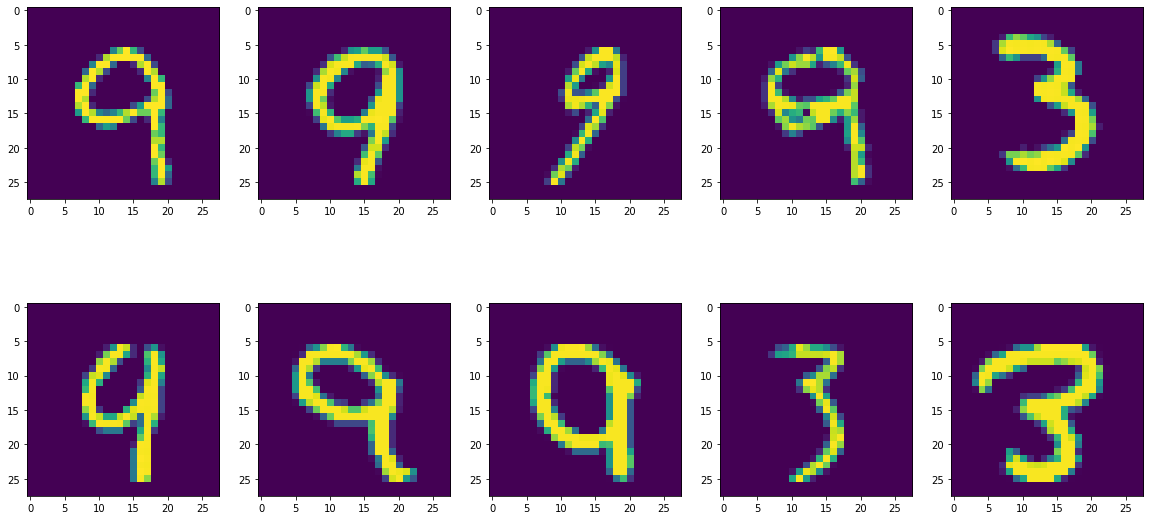

In [2]:
idx = np.where(np.isin(train_y,[3,9]))[0]
Mnist_39 = train_x[idx]

plt.figure(figsize= (20,10))
for i,image in enumerate(random.sample(range(0,Mnist_39.shape[0]),10)):
    plt.subplot(2,5,i+1)
    plt.imshow(Mnist_39[image].reshape(28,28))

# Step2
## Preprocessing: reduce its dimensionality
* By using EigenSpaces

In [6]:
cov = np.cov(Mnist_39.T)
print("Covarince",cov.shape)

Covarince (784, 784)


In [7]:
from scipy.linalg import eigh
cov = np.cov(Mnist_39.T)
def Reduce_dim(dim):
    e_values, e_vectors = eigh(cov,eigvals=(783-dim+1,783))
    return np.matmul(e_vectors.T, Mnist_39.T)

dim2 = Reduce_dim(2)
dim5 = Reduce_dim(5)
dim10 = Reduce_dim(10)

In [8]:
e_values, e_vectors = eigh(cov)
print("Eigen_values",e_values.shape)
print("Eigen_vectors",e_vectors.shape)

Mnist_39 = Mnist_39.T
print("\nMnist_39",Mnist_39.shape)
print("dim2",dim2.shape)
print("dim5",dim5.shape)
print("dim10",dim10.shape)

Eigen_values (784,)
Eigen_vectors (784, 784)

Mnist_39 (784, 10089)
dim2 (2, 10089)
dim5 (5, 10089)
dim10 (10, 10089)


# Step3: K-means

In [9]:
def K_Means(k, data, iteration = 25):
    data = data.T
    
    # step1: Select k init value
    N = data.shape[0]
    label = np.zeros(N)
    init = random.sample(range(N),k)
    init_center = data[init]

    # step2: K Means
    while(1):
        
        # labeling
        for idx, center in enumerate(init_center):
            if idx == 0:
                base = np.sum((data - center)**2, axis = 1) 
                base = np.expand_dims(base,0) # dim = (1,10089) 
            else:
                temp = np.sum((data - center)**2, axis = 1)
                temp = np.expand_dims(temp,0)
                base = np.concatenate([base,temp], axis = 0) # dim = (k,10089) 
        
        # Change labels
        before_label = label
        label = np.argmin(base, axis = 0)
        
        # Terminate condition
        if np.all(before_label == label) and np.unique(label).size == k:
            break
        
        # New Center
        for cluster in range(k):
            cluster_index = np.where(np.isin(label, cluster))
            if cluster == 0:
                temp = np.mean(data[cluster_index], axis = 0)
                new_center = np.expand_dims(temp,0)
            else:
                temp = np.mean(data[cluster_index], axis = 0)
                temp = np.expand_dims(temp,0)
                new_center = np.concatenate([new_center,temp], axis = 0)
        init_center = new_center
    return init_center, label


# Step4: Visualization

In [12]:
K_list = [2,3,5,10]

def Visualization(data):
    plt.figure(figsize= (15,10))
    for idx,k in enumerate(K_list):
        centers,labels = K_Means(k, data)
        plt.subplot(2,2,idx+1)
        X,Y = np.unique(labels, return_counts = True)
        ax = sns.barplot(X,Y)
        plt.xlabel("Class")
        plt.ylabel("Count")

        total_value = 0
        for cluster,p in enumerate(ax.patches):
            left, bottom, width, height = p.get_bbox().bounds
            index = np.where(np.isin(labels,cluster))[0]
            value = np.std(Mnist_39[:,index])
            total_value += value
            ax.annotate("%.4f"%(value), xy=(left+width/2, bottom+height/2), ha='center', va='center')
        plt.title("k = {} & Mean of intra-cluster variation {:.4f}".format(k, total_value/k))
        
        

# Raw data

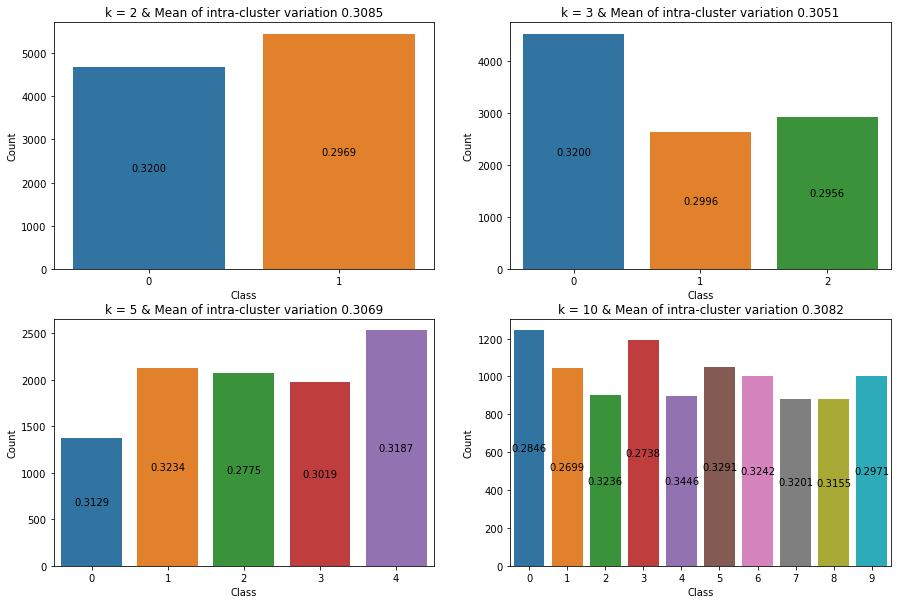

In [13]:
Visualization(Mnist_39)

# dim = 2
*  Plot the grouped clusters
*  Each red dot means the center of cluster

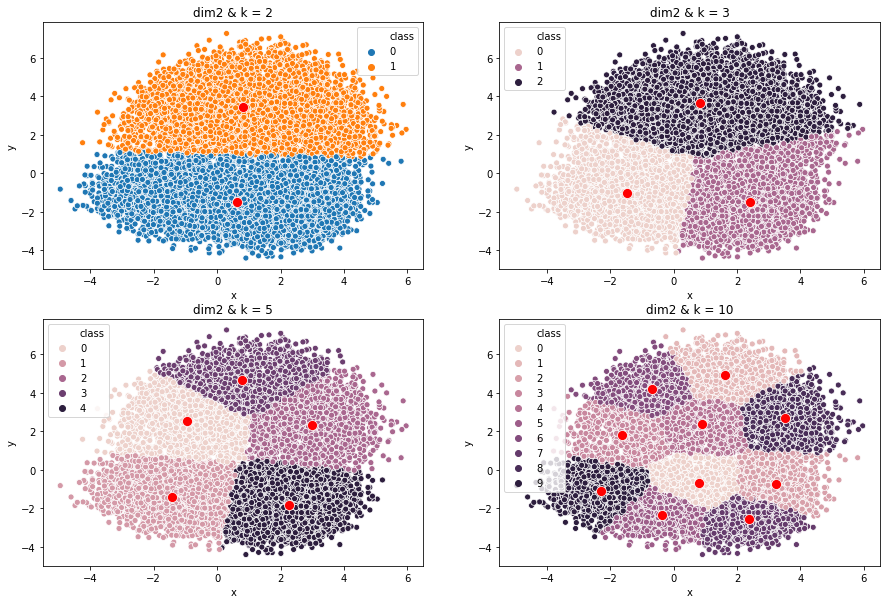

In [14]:
plt.figure(figsize= (15,10))
for idx,k in enumerate(K_list):
    centers,labels = K_Means(k, dim2)
    #print(np.unique(labels, return_counts = True))
    plt.subplot(2,2,idx+1)
    
    # visualization
    df = pd.DataFrame(dim2.T)
    df = pd.concat([df, pd.Series(labels)], axis = 1)
    df.columns = ['x','y','class']
    sns.scatterplot(x = 'x', y= 'y', hue = 'class', data = df, legend= "full")
    sns.scatterplot(centers.T[0], centers.T[1], palette = 'red',color = "r", s=100)
    plt.title("dim2 & k = {}".format(k))   


# Dim = 5

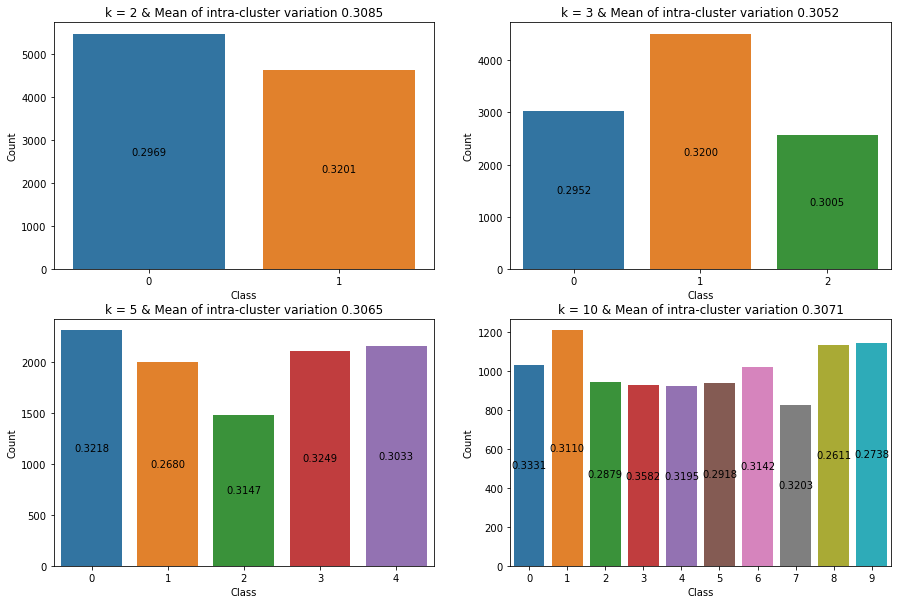

In [15]:
Visualization(dim5)

# Dim = 10

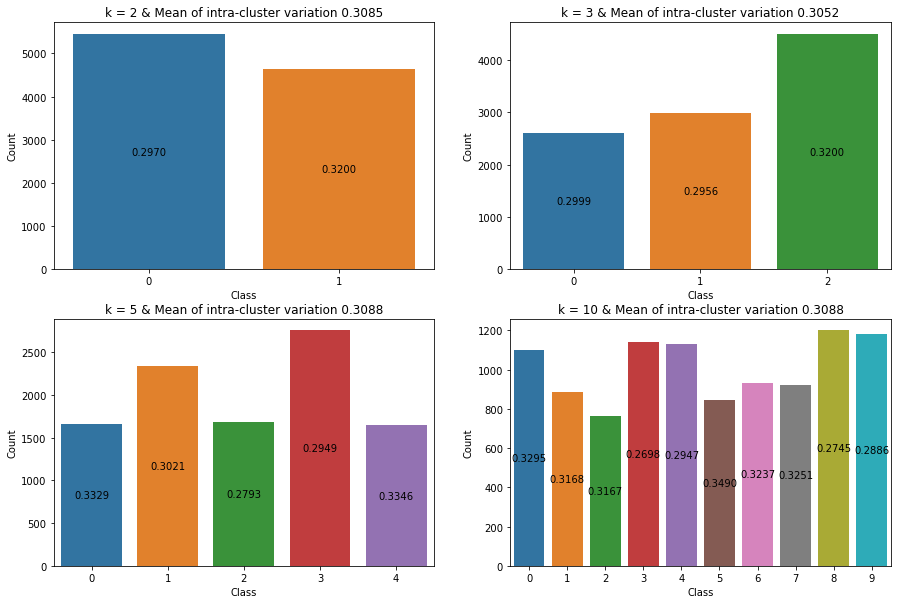

In [16]:
Visualization(dim10)